# Play with Kilosort output - 2

In this example, we want to create a spike bank for Neuropixel data from SpikeGLX.

In [ ]:
# Import the module to create the spike bank
from fklab.spikes.Kilosort import Data2SpikeCollection

Files need for this part are the output of Kilosort : 
- params.py
- all *.npy
- raw data (same as the path indicated by the file params.py)

In [ ]:
# Parameters :
kilosort_path = path1  # "/Path/To/Kilosort/params.py"  # Always pointing on the params.py file from Kilosort output
windows_time = 2  # - windows time for the spike in ms
nbr_neighboroud = 20  # - Number of neighbored channels to be save for each spike

result = Data2SpikeCollection(kilosort_path, windows_time, nbr_neighboroud)

The object result is instantiate by the Data2SpikeCollection class. This class is taking care of creating the spike collection. But it has the particularity to be herited from the class KiloSortResult. See the notebook about kilosort result to see what are its other available feature.
We are in this notebook interested only by the spike collection creation.

**Parameters of interests** : 
- spike_index : give a subset of spike index of your interested. If not, will compute for every spike detected by Kilosort
- filtering (false for spikeGLX, true for the others)

**Outputs**: both saved in the same location as the kilosort folder
- spikes.zarr folder : where the generated spike waveforms are saved
- metadata.yaml: to map the indices of the saved spikes to the spike ID from kilosort, which is useful when generating the waveforms for subsets of identified spikes (an example of how this can be used is shown at the end of this notebook)


**Note**: 
- It will take a long time to process every spike and create a zarr file for each spike. Be careful to the available time computation and free memory
- If the spikes.zarr already exists, newly generated spikes will be appended. The same goes for the metada.yaml.

In [ ]:
# The zarr file is saved in the same place in the kilosort folder with the name spikes.zarr
index = 42763  # We select a spike present in a good cluster just for the example

result.data2spike(spike_id=[42763], filtering=False)

1 / 1
nChan: 385, nFileSamp: 36053916


The advantage is you can start to explore the first spikes in a separate notebook. You can see more about how extracting spikes from a good cluster in the next notebook. 

/!\ To do this step, you need to have already the manual curation done with the Phy output (cluster_info.[ct]sv)

In waiting see an example of data saved : 

- 20 channels
- 2ms window size
- Neuropixels from spikeGLX

(1, 20, 60)


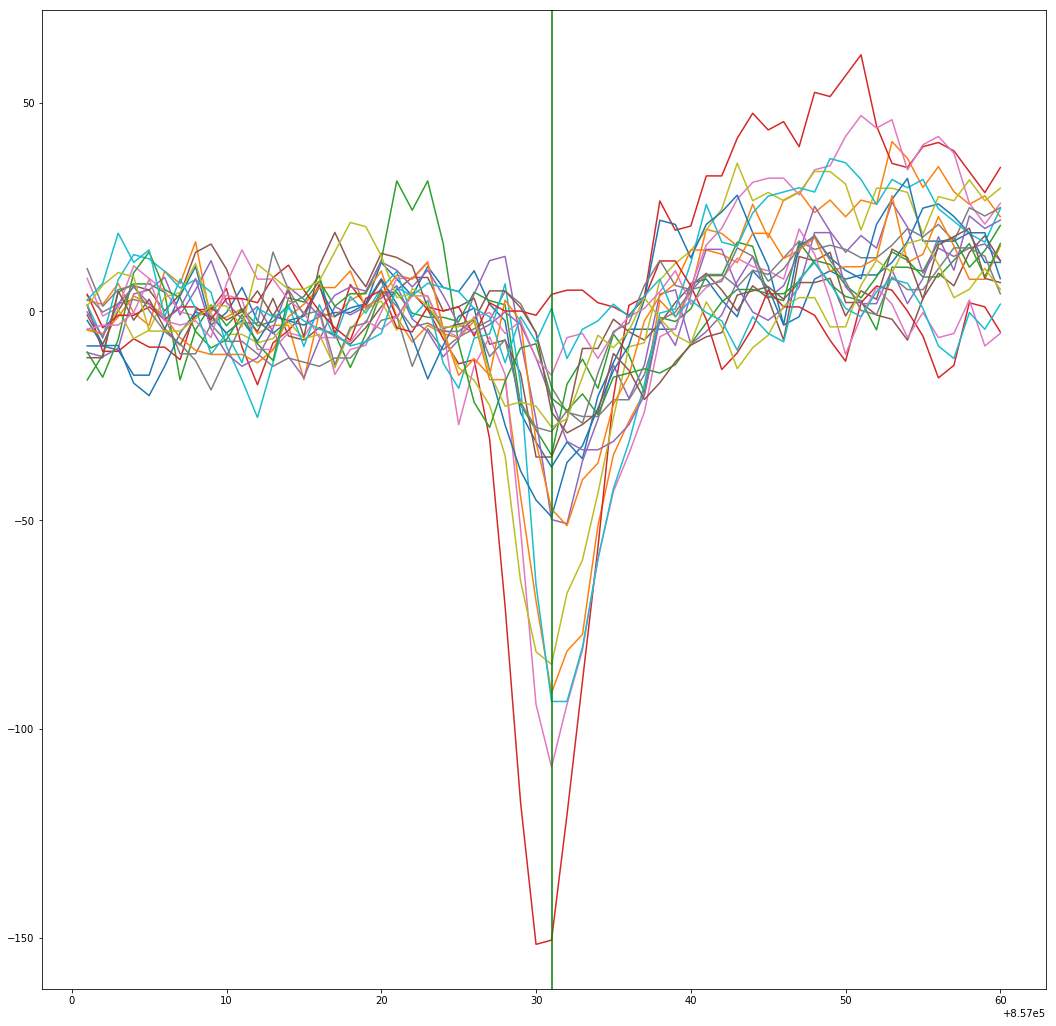

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yaml
import zarr
import os
from pathlib import Path


# Load the spikes.zarr created in the kilosort folder
data = zarr.load(os.path.join(str(Path(kilosort_path).parent), "spikes.zarr"))
raw_data = data[0]  # => in our example, we generated only one spike

x = range(int(result.spike_time[index]) - 30, int(result.spike_time[index]) + 30)
fig = plt.figure(figsize=(18, 18))
for i in range(0, 20):
    plt.plot(x, raw_data[i])

for spike_time in result.spike_time:
    if spike_time in x:
        plt.axvline(result.spike_time[index], color="g")
    elif spike_time > int(result.spike_time[index]) + 60:
        break
plt.show()

If you want know more about how the spike collection is computed, below there an example with the same spike id: 

This spike occurs a the sample 857031
And it is part of the template [59]
The 20 major channels where it occurs in decreasing importance are [365 367 363 366 369 361 368 371 364 370 362 372 374 359 373 375 357 360
 358 355]
And then, we obtain the same figure as before


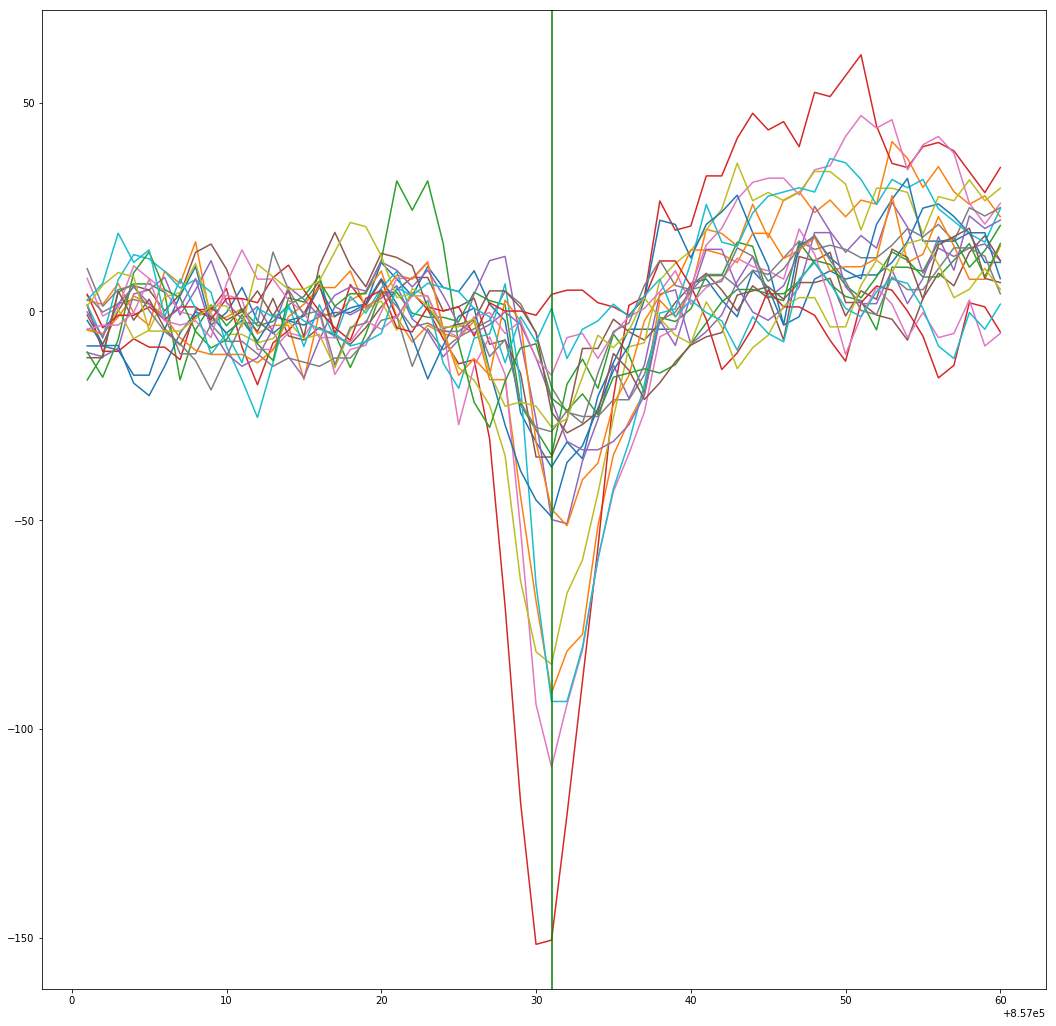

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

index = 42763
nbr_channels = 20
time_window = 2  # ms

spike_time = int(result.spike_time[index])
print("This spike occurs a the sample " + str(spike_time))
window = int((time_window / 1000) * result._channel_sample_rate)  # samples

template_id = result.spike_template[index]
print("And it is part of the template " + str(template_id))

channels = result.get_channels_for_template(
    int(template_id), count=nbr_channels, sort_channel=True
)
print(
    "The 20 major channels where it occurs in decreasing importance are "
    + str(channels)
)
print("And then, we obtain the same figure as before")

fig = plt.figure(figsize=(18, 18))
min_win = spike_time - int(window / 2)
max_win = spike_time + int(window / 2)

for i, channel in enumerate(channels):
    data = result.channel_data[channel][min_win:max_win] - np.mean(
        result.channel_data[channel][min_win:max_win]
    )
    plt.plot(range(min_win, max_win), data)

plt.axvline(spike_time, color="g")
plt.show()

**Case example: Generating and plotting the spike waveforms belonging to one or several particular clusters** : 

Let's for example generate all the spikes belonging to clusters that were identified as "good" in phy.

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import zarr
import os
from pathlib import Path

from fklab.utilities import yaml 
from fklab.spikes.Kilosort import Data2SpikeCollection
from fklab.spikes.Kilosort import KiloSortResult



In [ ]:
result = KiloSortResult(kilosort_path)

windows_time = 2  # - windows time for the spike in ms
nbr_neighboroud = 8  # - Number of neighbored channels to be save for each spike

# select good clusters
good_clusters_id = result.get_cluster_group("good")

# get all spike IDs from each selected clusters
spike_IDs = [
    np.nonzero(result.spike_cluster == sel_cl)[0] for sel_cl in good_clusters_id
]

# at this point the imputs to data2spike needs to be a list of 1-d list: [[spike_id], [spike_id], [spike_id]]
spike_IDs = (
    np.concatenate(spike_IDs).reshape(np.concatenate(spike_IDs).shape[0], -1).tolist()
)

# let's generate those spikes
generate_spikes = Data2SpikeCollection(kilosort_path, windows_time, nbr_neighboroud)
spikes.data2spike(spike_id=IDs, filtering=False)

We now load and plot the waveforms of spikes belonging to one particular custer (which goes by the sweet name: 24)

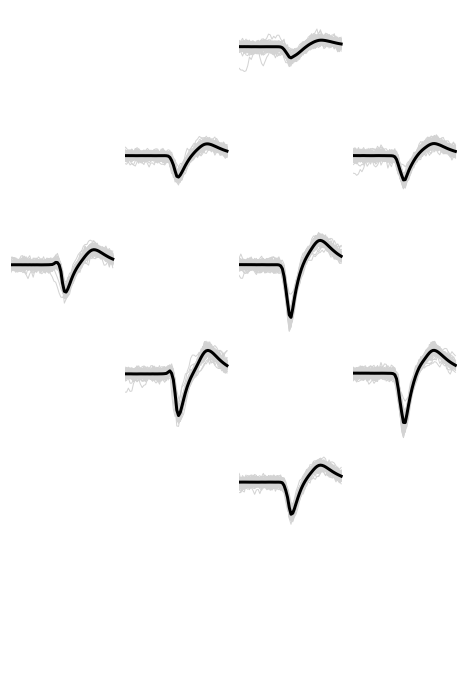

In [ ]:
# Load the spikes.zarr and metadata created in the kilosort folder
data = zarr.load(os.path.join(str(Path(kilosort_path).parent), "spikes.zarr"))
metadata = yaml.load(
    open(os.path.join(str(Path(kilosort_path).parent), "metadata.yaml"))
)

all_generated_spikes = np.concatenate(metadata["spike_id"])

cluster = 24

# get cluster's spike waveforms
spike_ids = np.nonzero(result.spike_cluster == cluster)[0]
wf = data[np.array([np.where(all_generated_spikes == s)[0][0] for s in spike_ids])]

# compute spike waveforms mean
mean_wf = np.mean(wf, axis=0)

# get N randomly picked single waveforms
N = 100
random_wf = wf[np.random.randint(len(wf), size=N)]

# get channel mapping and construct one for plotting
channels_id = result.get_channel_for_cluster(cluster, count=nbr_neighboroud)
channels_pos = result.get_channel_pos(channels_id)

row = np.unique(channels_pos[:, 0])
columns = np.unique(channels_pos[:, 1])

ax_pos = np.empty(channels_pos.shape)
for i in range(len(channels_pos)):
    ax_pos[i, 0] = np.where(row == channels_pos[i, 0])[0]
    ax_pos[i, 1] = np.where(columns == channels_pos[i, 1])[0]


# Now we can plot
f, ax = plt.subplots(
    len(columns) + 1, len(row), sharey=True, sharex=True, figsize=(8, 12)
)

for i in range(nbr_neighboroud):

    pos = ax_pos[i].astype("int")

    # the single waveforms
    for w in random_wf[:, i, :]:
        ax[pos[1]][pos[0]].plot(w, color="lightgrey", lw=1.0)

    # the mean waveforms
    ax[pos[1]][pos[0]].plot(mean_wf[i], color="black", lw=3.0)

# with a bit of figure formatting
ax[0][0].set(xlim=(0, 60), yticks=[], xticks=[])
plt.subplots_adjust(hspace=0, wspace=0.1)
sns.despine(left=True, bottom=True)

Aren't these nice looking spikes ?!?